# Retinal OCT Imaging
<hr style="border:2px solid pink">

## Introduction

#### Background

Retinal optical coherence tomography (OCT) is a noninvasive imaging technique that essentially takes pictures of your retinas by measuring how much light reflects off the retina and optic nerve. It can be used to diagnose and manage diseases like diabetes-related retinopathy and glaucoma, amongst others. Millions of OCT scans are performed each year, and the analysis and interpretation of the images can take up a tremendous amount of time.

#### Business Problem

In order to save time and resources in analyzing and interpreting OCT scans, the problem at hand is to create a model that can predict whether a patient's retinal scan is normal or shows signs of CNV, DME, or DRUSEN diseases. 

The stakeholders are medical professionals, specifically ophthalmologists.

#### Data Understanding

The data for this project comes from Kaggle: https://www.kaggle.com/datasets/paultimothymooney/kermany2018/data. It
contains 84,495 images, and 4 categories to predict (NORMAL, CNV, DME, or DRUSEN). 

The data is split into separate train, test, and validation folders. Within each of these, there are labeled sub-folders for each category, with each individual image labeled as such: (disease)-(randomized patient ID)-(image number by
this patient).

The images were selected from adult patients from the Shiley Eye Institute of the University of California San Diego, the California Retinal Research Foundation, Medical Center Ophthalmology Associates, the Shanghai First People’s Hospital, and Beijing Tongren Eye Center between July 1, 2013 and March 1, 2017. 

#### Definitions

According to the National Library of Medicine, the following terms are defined as follows: 

1. CNV: (Choroidal Neovascularization): a condition where abnormal blood vessels grow beneath the retina in the choroid area. These abnormal blood vessels can leak fluid or blood into the retina, which can cause vision loss. Commonly associated with age-related macular degeneration (AMD), which is a leading cause of vision loss in older adults.

2. DME (Diabetic Macular Edema): a complication of diabetic retinopathy, which is an eye condition that can develop in people with diabetes. DME occurs when fluid builds in the macula, the central part of the retina responsible for our central vision, leading to to vision impairment and distortion.

3. Drusen: small yellow or white deposits that accumulate in the retina. They can be found in the macula or the peripheral retina. Drusen are a hallmark sign of age-related macular degeneration (AMD). 

Treatment options for CNV, DME, and AMD may include medications, laser therapy, or in some cases, surgical interventions, depending on the specific condition and its stage.
<hr style="border:2px solid pink">

# General Exploration

To get started, let's import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.image import imread
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, StratifiedKFold

from sklearn.metrics import confusion_matrix, classification_report, make_scorer,\
recall_score,accuracy_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import warnings
warnings.filterwarnings('ignore')

Let's load in the data next. We need to create directories to where the data is saved, so let's start with that. 

In [2]:
# create directory paths for each folder (train, test, and val)
train_path = '../Data/OCT2017/train'
test_path = '../Data/OCT2017/test'
val_path = '../Data/OCT2017/val'

We'll load in the data normally, no scaling or augmentations done, setting smaller batch sizes, and setting seed=42 to help with reproducibility. 

In [3]:
original_train = ImageDataGenerator().flow_from_directory(train_path, batch_size=200, seed=42)
original_test = ImageDataGenerator().flow_from_directory(test_path, batch_size=100, seed=42)
original_val = ImageDataGenerator().flow_from_directory(val_path, batch_size=5, seed=42)

original_train_images, original_train_labels = next(original_train)
original_test_images, original_test_labels = next(original_test)
original_val_images, original_val_labels = next(original_val)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


Notice that there are 4 classes: This represents normal, CNV, DME, or Drusen. Before visualizing the distribution, let's find out the original size of the images. We can loop through every image in the images datasets, take the size of it, add it to a list, and take the unique values of the list to confirm each image is the same size. But first, let's look at the shape as this should tell us the size as well. 

In [4]:
print(f"Train Images Shape: {original_train_images.shape}")
print(f"Train Labels Shape: {original_train_labels.shape}")
print(f"Test Images Shape: {original_test_images.shape}")
print(f"Test Labels Shape: {original_test_labels.shape}")
print(f"Val Images Shape: {original_val_images.shape}")
print(f"Val Labels Shape: {original_val_labels.shape}")

Train Images Shape: (200, 256, 256, 3)
Train Labels Shape: (200, 4)
Test Images Shape: (100, 256, 256, 3)
Test Labels Shape: (100, 4)
Val Images Shape: (5, 256, 256, 3)
Val Labels Shape: (5, 4)


It looks like each image is 256x256, but let's confirm this with the loop.

In [5]:
# loop through each images in the array and add the size to an empty list
train_sizes = []
test_sizes = []
val_sizes = []

for img in original_train_images:
    size = np.array(array_to_img(img).size)
    train_sizes.append(size)
    
for img in original_test_images:
    size = np.array(array_to_img(img).size)
    test_sizes.append(size)
    
for img in original_val_images:
    size = np.array(array_to_img(img).size)
    val_sizes.append(size)

In [6]:
# how many unique sizes are in each list? theoretically should be the same for each pic
# change the list of np arrays into a list of tuples, then take the "set" to get unique values

unique_train_sizes = list(set([tuple(size) for size in train_sizes]))
unique_test_sizes = list(set([tuple(size) for size in test_sizes]))
unique_val_sizes = list(set([tuple(size) for size in val_sizes]))

print(f"Original Train Image Size: {unique_train_sizes}")
print(f"Original Test Image Size: {unique_test_sizes}")
print(f"Original Val Image Size: {unique_val_sizes}")

Original Train Image Size: [(256, 256)]
Original Test Image Size: [(256, 256)]
Original Val Image Size: [(256, 256)]


Great! So the original images were indeed all 256x256. Since I noticed when loading in the data that there are 4 classes, let's now take a look at the distribution of the images in our dataset. 

In [7]:
# first, create paths to each individual folder
normal_train_path = '../Data/OCT2017/train/NORMAL'
cnv_train_path = '../Data/OCT2017/train/CNV'
dme_train_path = '../Data/OCT2017/train/DME'
drusen_train_path = '../Data/OCT2017/train/DRUSEN'

# then, take the "length" of each folder to get the total number of images per category
normal_count = len(os.listdir(normal_train_path))
cnv_count = len(os.listdir(cnv_train_path))
dme_count = len(os.listdir(dme_train_path))
drusen_count = len(os.listdir(drusen_train_path))

# print the results
print(f'Normal Count: {normal_count}')
print(f'CNV Count: {cnv_count}')
print(f'DME Count: {dme_count}')
print(f'Drusen Count: {drusen_count}')

Normal Count: 26315
CNV Count: 37205
DME Count: 11348
Drusen Count: 8616


So, there are 26,315 normal images, 37,205 CNV images, 11,348 DME images, and 8,616 Drusen images. Let's visualize the distribution. 

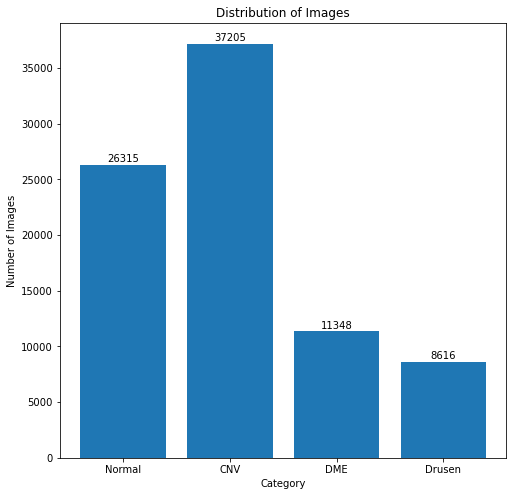

In [8]:
# create the categories for X (categories) and Y (counts)
categories = ['Normal', 'CNV', 'DME', 'Drusen']
counts = [normal_count, cnv_count, dme_count, drusen_count]

# plot it
fig, ax = plt.subplots(figsize=(8,8))
plt.bar(categories, counts)
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Images')

# add counts to the top of the bars
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

plt.show();

This makes the distributions a little more clear! There's the most CNV images and the least Drusen images. Another thing to note is that our dataset it imbalanced - it may be beneficial to try data augmentation when modeling.

Let's look at a few images and labels, so we can get an idea of what we're dealing with. 

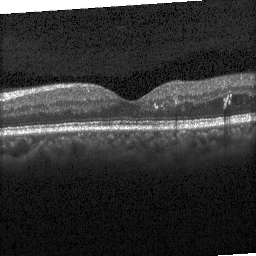

In [9]:
array_to_img(original_train_images[16])

In [10]:
original_train_labels[16]

array([0., 1., 0., 0.], dtype=float32)

In [11]:
original_train.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

Ok, so here, I see that each category corresponds to a class. CNV is class 0, DME is class 1, DRUSEN is class 2, and NORMAL is class 3. 

You would interpret the array [0., 1., 0., 0.] as follows: the first class (index 0, corresponds to CNV) has a probability of 0. The second class (index 1, corresponds to DME) has a probability of 1. The third class (index 2, corresponds to Drusen) and the fourth class (index 3, corresponds to normal) have probabilities of 0. This means that the image falls under class 1, and is DME. 

Let's plot a few images from each class, with their corresponding labels titling the plot.

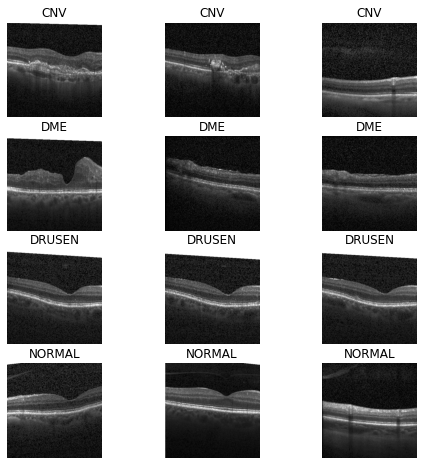

In [12]:
# we have paths to each subfolder, so create a list paths that has them all
# create a list categories with each of the subfolders for labeling purposes
paths = [cnv_train_path, dme_train_path, drusen_train_path, normal_train_path]
categories = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
fig, axes = plt.subplots(nrows=len(categories), ncols=3, figsize=(8, 8))

# iterate through paths to get the image path
for index, path in enumerate(paths):
    image_files = [file for file in os.listdir(path) if file.endswith('.jpeg')]
    
    # Limit the number of images to fit the layout
    total_images_per_cat = min(len(image_files), 3)
    
    for i in range(total_images_per_cat): 
        image_file = image_files[i]
        image_path = os.path.join(path, image_file)
        image = imread(image_path)
        image = image[:400, :400]
            
        # Display the image in a subplot
        ax = axes[index, i]
        ax.imshow(image, cmap='gray')
        ax.set_title(categories[index])  # Display the label
        ax.axis('off')

plt.show()

Great! So we have a little better understanding of what each image might look like. Let's start preprocessing so we can start modeling. 

# Preprocessing

To preprocess the data for a convolutional neural network, I'd like to start the following: 
1. Scale the data: CNNs are sensitive to the scale of input features. By scaling the data, you ensure numerical stability during training. For images, pixel values are usually in the range [0,255], so you can rescale them to the range [0,1] by dividing each pixel by 255.
2. Resize the images: Smaller images can be less computationally intensive, leading to faster training times. This will also help ensure all inputs have the same shape. I will start with decreasing the size to 64x64.
3. Set the seed: To help with reproducibility, I will set the seed equal to 42. 
4. Set the color mode: Since these images are originally in black and white, I will set the color_mode to grayscale to capture this. 
5. Set data augmentation filters: we'll add filters such as flipping, shifting, rotating, and adjusting the brightness/zoom/shearness of the images. This will randomly apply these transformations to the images in order to add more data to the training set only, adding variety into our model and increasing the size of the training set. 

In [13]:
# load in and preprocess the data in smaller batches
# Scale and transform the images, reshape to be 64x64, set the seed, and set the color to grayscale

target_size = (64,64)
train_generator = ImageDataGenerator(rescale=1.0/255.0, 
                                     horizontal_flip=True,
                                     height_shift_range=0.2,
                                     width_shift_range=0.2,
                                     rotation_range=45,
                                     brightness_range=[0.4,1],
                                     zoom_range=0.2, 
                                     shear_range=0.2
                                     ).flow_from_directory(train_path, 
                                                           target_size=target_size, 
                                                           batch_size=500, 
                                                           seed=42, 
                                                           color_mode='grayscale') 

test_generator = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(test_path, 
                                                                         target_size=target_size, 
                                                                         batch_size=100, 
                                                                         seed=42, 
                                                                         color_mode='grayscale')

val_generator = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(val_path, 
                                                                        target_size=target_size, 
                                                                        batch_size=5, 
                                                                        seed=42, 
                                                                        color_mode='grayscale')

# next fetches the next batch of data and labels from the generator
# returns a batch of images and their labels
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


Great! Let's check out the following to make sure everything was properly loaded. 
1. Check out the shapes - everything should be rescaled to 64x64. 
2. Check out the images - everything should be in black and white and smaller in size. 

In [14]:
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")
print(f"Val Images Shape: {val_images.shape}")
print(f"Val Labels Shape: {val_labels.shape}")

Train Images Shape: (500, 64, 64, 1)
Train Labels Shape: (500, 4)
Test Images Shape: (100, 64, 64, 1)
Test Labels Shape: (100, 4)
Val Images Shape: (5, 64, 64, 1)
Val Labels Shape: (5, 4)


The shapes all look good! We can see that they are indeed 64x64 for the images, with the color channel as 1, indicating it is grayscale. Next, let's check out a few images. 

In [15]:
train_generator.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

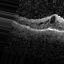

In [16]:
array_to_img(train_images[0])

In [17]:
# second value has probability of 1, so this DME
print(train_labels[0])

[0. 1. 0. 0.]


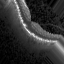

In [18]:
array_to_img(train_images[3])

In [19]:
# last value has probability of 1, so this is normal
print(train_labels[3])

[0. 0. 0. 1.]


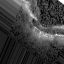

In [20]:
array_to_img(train_images[6])

In [21]:
# first value has probability of 1, so this is CNV
print(train_labels[6])

[1. 0. 0. 0.]


The images look good, they are in black and white, and scaled down to 64x64. 

For this notebook, let's change this to a binary classification and see if we can get better results than multiclass.

# Creating Binary Labels

In [ ]:
# multiclass is doing terribly
# limitations of binary: this will lose the individuality of the different abnormalities
# could just do abnormal vs normal, and any abnormality you would go in for a second scan regardless

# the model will always predict class 1
# there are more abnormalities (CNV, DME, DRUSEN) than normal
# using abnormalities as class 1 could result in the model predicting the majority class every time
# but we want to predict if there is something off about the scan
# could predict if it is normal (class 1) and if it is not, then it is abnormal (class 0)

# so now, create binary labels. Anything abnormal (CNV, DME, Drusen) will be class 0 and normal will be class 1

In [22]:
# check the distribution
abnormal_count = cnv_count + dme_count + drusen_count
print(f'Total Abnormal: {abnormal_count}')
print(f'% Abnormal: {round(abnormal_count/(abnormal_count + normal_count),2)}')
print('------------------------')
print(f'Total Normal: {normal_count}')
print(f'% Normal: {round(normal_count/(abnormal_count + normal_count),2)}')

Total Abnormal: 57169
% Abnormal: 0.68
------------------------
Total Normal: 26315
% Normal: 0.32


In [23]:
train_generator.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

In [24]:
# For training data
# calculate the index of the max value in each row (i.e., is it cnv, dme, drusen, or normal)
# np.where changes the values so that anything index 3 is turned into 1 and everything else is a 0
max_indices_train = train_labels.argmax(axis=1)
binary_train_labels = np.where(max_indices_train == 3, 1, 0)

# For testing data
max_indices_test = test_labels.argmax(axis=1)
binary_test_labels = np.where(max_indices_test == 3, 1, 0)

# For validation data
max_indices_val = val_labels.argmax(axis=1)
binary_val_labels = np.where(max_indices_val == 3, 1, 0)

Confirm it worked. 

In [ ]:
# normal

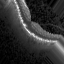

In [25]:
array_to_img(train_images[3])

In [26]:
# original label
# last value has probability of 1, so this is normal. should be class 1 in binary
print(train_labels[3])

[0. 0. 0. 1.]


In [27]:
print(binary_train_labels[3])

1


In [ ]:
# dme

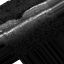

In [28]:
array_to_img(train_images[16])

In [29]:
# original label
# second value has probability of 1, so this is dme. should be class 0 in binary
print(train_labels[16])

[0. 1. 0. 0.]


In [30]:
print(binary_train_labels[16])

0


In [ ]:
# cnv

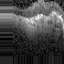

In [128]:
array_to_img(train_images[1])

In [129]:
# original label
# first value has probability of 1, so this is cnv. should be class 0 in binary
print(train_labels[1])

[1. 0. 0. 0.]


In [130]:
print(binary_train_labels[1])

0


In [ ]:
# drusen

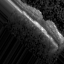

In [131]:
array_to_img(train_images[87])

In [150]:
# original label
# first value has probability of 1, so this is cnv. should be class 0 in binary
print(train_labels[88])

[0. 0. 1. 0.]


In [151]:
print(binary_train_labels[88])

0


# Creating Functions

Next, let's build some functions next to help speed up viewing the results of each model. 
1. A function that evaluates the model's train and test performance. 
2. A function to plot the loss and accuracy. 
3. A function to plot the confusion matrices. 

Let's start with the evaluate function. We'll print out the loss, accuracy, precision, and recall for both the train and test sets. 

In [34]:
# 1. a function that evaluates the train and test performance of the model
def evaluate_model(model):
    train_results = model.evaluate(train_images, binary_train_labels)
    test_results = model.evaluate(test_images, binary_test_labels)
    
    print(f'Training Loss: {train_results[0]:.3} \nTraining Accuracy: {train_results[1]:.3} \nTraining Precision: {train_results[2]:.3} \nTraining Recall: {train_results[3]:.3}')  
    print('---------------------------')
    print(f'Testing Loss: {test_results[0]:.3} \nTesting Accuracy: {test_results[1]:.3} \nTesting Precision: {test_results[2]:.3} \nTesting Recall: {test_results[3]:.3}')    

Next, let's create a function to plot the loss and accuracy for us. 

In [35]:
# 2. a function to plot the loss and accuracy
def plot_metrics(results):
    train_loss = results.history['loss']
    train_accuracy = results.history['accuracy']

    val_loss = results.history['val_loss']
    val_accuracy = results.history['val_accuracy']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label='train_accuracy')

    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label='val_accuracy')
    
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show();

Finally, let's create a function to plot the confusion matrix for us.

confusion matrix only plotting for individual batches, can't get it for the test set AFTER the train test split

In [52]:
# 3. a function to plot the confusion matrix
# UPDATE!!! I don't think this works anymore
def plot_confusion_matrix(model, test_images, binary_test_labels):
    y_pred = model.predict(test_images)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)

    cm = confusion_matrix(binary_test_labels, y_pred)
    cm_df = pd.DataFrame(cm, index=['ABNORMAL', 'NORMAL'], columns=['ABNORMAL', 'NORMAL'])

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

# Baseline model

For my baseline model, I will use the class distribution. Let's compare abnormal (CNV, DRUSEN, DME) and normal.

In [37]:
abnormal_count = cnv_count + dme_count + drusen_count
print(f'Total Abnormal: {abnormal_count}')
print(f'% Abnormal: {round(abnormal_count/(abnormal_count + normal_count),2)}')
print('------------------------')
print(f'Total Normal: {normal_count}')
print(f'% Normal: {round(normal_count/(abnormal_count + normal_count),2)}')

Total Abnormal: 57169
% Abnormal: 0.68
------------------------
Total Normal: 26315
% Normal: 0.32


So 68% abnormal, 32% normal. Normal is our class 1, so 32% is the baseline accuracy to beat. 

# First Simple Model

For my first simple model, I will use a simple convolutional neural network with no hidden convolutional layers. I will begin with a dense input layer, expecting grayscale images of size 64x64x1. The input layer will have 64 units and use the ReLU activation function to introduce non-linearity and capture complex features. Next, I will add a flatten layer to transform the output from the previous layer into a 1D vector, preparing it for the final output layer. The output layer will consist of a dense layer with 1 units to represent the binary classes, and it will use the sigmoid activation function, which is a common choice for binary classification tasks.

In [38]:
input_shape = (64, 64, 1)

In [39]:
model_1 = Sequential()
model_1.add(Dense(64, activation='relu', input_shape=input_shape))
model_1.add(Flatten())
model_1.add(Dense(1, activation='sigmoid'))

Let's view the architecture of the model. 

In [40]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64, 64, 64)        128       
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 262145    
Total params: 262,273
Trainable params: 262,273
Non-trainable params: 0
_________________________________________________________________


So we can see that there are a 262,273 parameters. Let's compile the model using the adam optimizer (Adam is a good starting choice because Adam is an adaptive learning rate optimization algorithm. It should help with a more efficient convergence), binary crossentropy as the loss (this is an appropriate choice for a binary classsification task), and accuracy, precision, and recall as the metrics. 

In [41]:
precision = Precision()
recall = Recall()

In [42]:
model_1.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy', precision, recall])

Finally, let's fit the model on the train set. I will use the following parameters: 
- Smaller batches of 100, meaning my model will process 100 training samples at a time before adjusting the weights. 
- 25 epochs: epochs specifies how many times the model will iterate over the entire dataset. 
- Validation split of 25%, so 25% of the training data will be set aside to test the model.

In [43]:
# set validation split = 25% of data, this is the holdout test set
model_1_results = model_1.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 1s 220ms/step - loss: 0.7686 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6436 - val_accuracy: 0.6720 - val_precision: 0.6316 - val_recall: 0.2609
Epoch 2/25
4/4 [==============================] - 0s 70ms/step - loss: 0.6287 - accuracy: 0.6880 - precision: 0.3582 - recall: 0.2449 - val_loss: 0.7254 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 [==============================] - 0s 73ms/step - loss: 0.5808 - accuracy: 0.7440 - precision: 1.0000 - recall: 0.0204 - val_loss: 0.6324 - val_accuracy: 0.6560 - val_precision: 0.7143 - val_recall: 0.1087
Epoch 4/25
4/4 [==============================] - 0s 95ms/step - loss: 0.5635 - accuracy: 0.7147 - precision: 0.3846 - recall: 0.1531 - val_loss: 0.6172 - val_accuracy: 0.6560 - val_precision: 1.0000 - val_recall: 0.0652
Epoch 5/25
4/4 [==============================] - 1s 161ms/step - loss: 0.5478 - accuracy: 0.7440 -

Great! Let's evaluate the scores. 

In [44]:
evaluate_model(model_1)

4/4 [==============================] - 0s 14ms/step - loss: 0.6178 - accuracy: 0.7300 - precision: 0.5000 - recall: 0.1481  
Training Loss: 0.409 
Training Accuracy: 0.834 
Training Precision: 0.93 
Training Recall: 0.458
---------------------------
Testing Loss: 0.618 
Testing Accuracy: 0.73 
Testing Precision: 0.5 
Testing Recall: 0.148


This is pretty overfit! We have a train accuracy of 83% and a test accuracy of 73%. Train precision is 93% and train recall is 46%, suggesting the model is doing a better job of minimizing false positives over false negatives (precision over recall) which is not what we want. (We want to prioritize recall **ADD IN WHY**). Testing precision and recall follow the same pattern, with respective scores of 50% and 16%. 

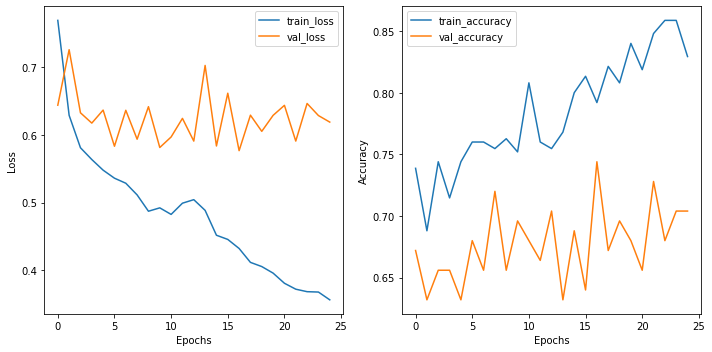

In [46]:
plot_metrics(model_1_results)

UPDATE LATER: 
Here, we can see that the train loss is decreasing, val loss is jumping all over the place, train accuracy is steadily increasing, but val accuracy is low. 

<Figure size 576x432 with 0 Axes>

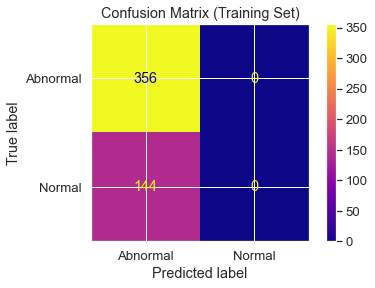

<Figure size 576x432 with 0 Axes>

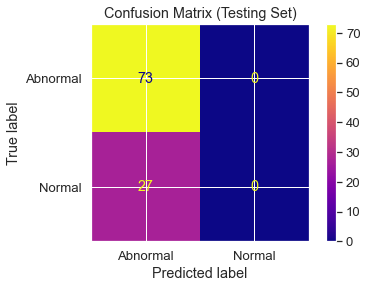

In [104]:
# Get predictions for the entire training and testing sets
predicted_labels_train = model_1.predict(train_images).argmax(axis=1)
predicted_labels_test = model_1.predict(test_images).argmax(axis=1)

# Create the confusion matrices
conf_matrix_train = confusion_matrix(binary_train_labels, predicted_labels_train)
conf_matrix_test = confusion_matrix(binary_test_labels, predicted_labels_test)

# Plot the confusion matrices using seaborn and matplotlib
labels = ['Abnormal', 'Normal']
sns.set(font_scale=1.2)

# Plot for the training set
plt.figure(figsize=(8, 6))
train_cm = ConfusionMatrixDisplay(conf_matrix_train, display_labels=labels)
train_cm.plot(cmap='plasma', values_format='d')
plt.title('Confusion Matrix (Training Set)')
plt.show();

# Plot for the testing set
plt.figure(figsize=(8, 6))
test_cm = ConfusionMatrixDisplay(conf_matrix_test, display_labels=labels)
test_cm.plot(cmap='plasma', values_format='d')
plt.title('Confusion Matrix (Testing Set)')
plt.show();

# Model #2

My first simple model was very overfit, let's try making it more complex and adding some hidden layers. Will add convolutional and max pooling. 

In [47]:
model_2 = Sequential()

model_2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Flatten())
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', precision, recall])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 12545     
Total params: 31,361
Trainable params: 31,361
Non-trainable params: 0
__________________________________________________

A lot less params. 

In [48]:
model_2_results = model_2.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 3s 772ms/step - loss: 0.6306 - accuracy: 0.7173 - precision: 0.3182 - recall: 0.0560 - val_loss: 0.7214 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
4/4 [==============================] - 2s 419ms/step - loss: 0.5988 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6760 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 [==============================] - 3s 635ms/step - loss: 0.5886 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6553 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
4/4 [==============================] - 2s 617ms/step - loss: 0.5817 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6677 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
4/4 [==============================] - 2s 442

In [49]:
evaluate_model(model_2)

4/4 [==============================] - 0s 35ms/step - loss: 0.4974 - accuracy: 0.7600 - precision: 0.5652 - recall: 0.4815
Training Loss: 0.434 
Training Accuracy: 0.81 
Training Precision: 0.818 
Training Recall: 0.438
---------------------------
Testing Loss: 0.497 
Testing Accuracy: 0.76 
Testing Precision: 0.565 
Testing Recall: 0.481


Slightly lower scores for training and higher for testing. Train accuracy at 81%, precision and 82% and recall at 44%. Test accuracy at 76%, precision at 57%, and recall at 48%. Still higher recall than precision. 

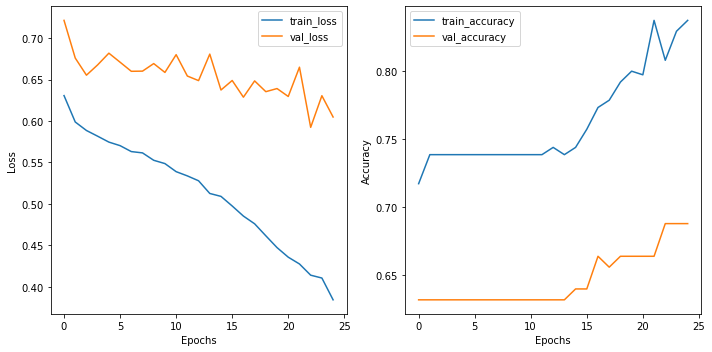

In [54]:
plot_metrics(model_2_results)

# Model #3

Let's add more complexity - more conv and 2d layers, add some dense layers, and add dense layer after flatten. 

In [55]:
model_3 = Sequential()

model_3.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_3.add(MaxPooling2D(pool_size=(2,2)))

model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))

model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))

model_3.add(Flatten())
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

More params than first model, less than baseline. Fit the model. 

In [56]:
model_3_results = model_3.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 3s 652ms/step - loss: 0.6649 - accuracy: 0.7227 - precision: 0.4545 - recall: 0.1200 - val_loss: 0.6539 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
4/4 [==============================] - 2s 377ms/step - loss: 0.5774 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7941 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 [==============================] - 2s 440ms/step - loss: 0.6176 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6593 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
4/4 [==============================] - 2s 385ms/step - loss: 0.5898 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6502 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
4/4 [==============================] - 1s 367

In [57]:
evaluate_model(model_3)

4/4 [==============================] - 0s 34ms/step - loss: 0.7620 - accuracy: 0.4700 - precision: 0.3333 - recall: 0.9630
Training Loss: 0.498 
Training Accuracy: 0.77 
Training Precision: 0.675 
Training Recall: 0.389
---------------------------
Testing Loss: 0.762 
Testing Accuracy: 0.47 
Testing Precision: 0.333 
Testing Recall: 0.963


Worse scores all around. 

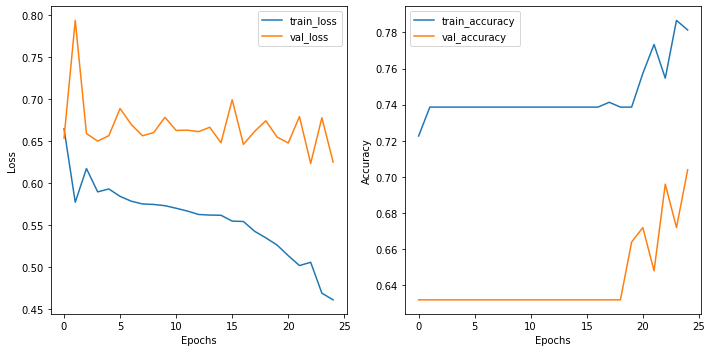

In [58]:
plot_metrics(model_3_results)

Let's try increasing the input units. Same model as second model otherwise. 

# Model #4

In [65]:
model_4 = Sequential()

model_4.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Conv2D(128, (3, 3), activation='relu')) # increased from 64 to 128
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Conv2D(64, (3, 3), activation='relu')) # increased from 32 to 64
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Flatten())
model_4.add(Dense(64, activation='relu')) # increased from 32 to 64
model_4.add(Dense(32, activation='relu')) # increased from 16 to 32
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)             

More params!

In [66]:
model_4_results = model_4.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 2s 457ms/step - loss: 0.6407 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7180 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
4/4 [==============================] - 2s 504ms/step - loss: 0.5959 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6556 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 [==============================] - 3s 641ms/step - loss: 0.6007 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6533 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
4/4 [==============================] - 2s 604ms/step - loss: 0.5906 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6958 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
4/4 [==============================] 

In [67]:
evaluate_model(model_4)

4/4 [==============================] - 0s 33ms/step - loss: 0.4655 - accuracy: 0.8100 - precision: 0.7857 - recall: 0.4074
Training Loss: 0.5 
Training Accuracy: 0.748 
Training Precision: 0.95 
Training Recall: 0.132
---------------------------
Testing Loss: 0.466 
Testing Accuracy: 0.81 
Testing Precision: 0.786 
Testing Recall: 0.407


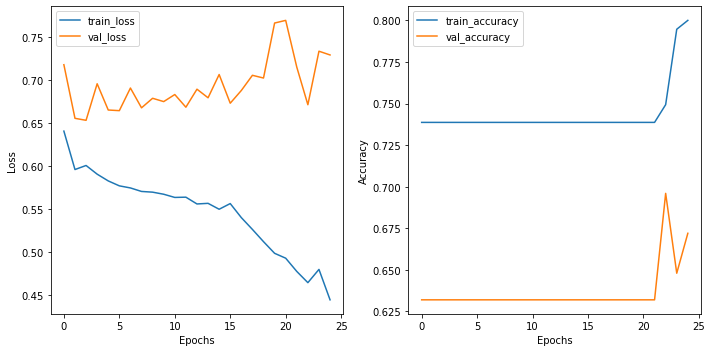

In [68]:
plot_metrics(model_4_results)

Worse train accuracy and recall, better precision. Better test accuracy, precision, and ok recall. 

Let's try adding regularization. 

# Model #5

Add regulurization, start with just L2. 

In [69]:
model_5 = Sequential()

model_5.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.01)))

model_5.add(MaxPooling2D(pool_size=(2,2)))

model_5.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_5.add(MaxPooling2D(pool_size=(2,2)))

model_5.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_5.add(MaxPooling2D(pool_size=(2,2)))

model_5.add(Flatten())
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)             

In [70]:
model_5_results = model_5.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 3s 735ms/step - loss: 1.9825 - accuracy: 0.6693 - precision: 0.4062 - recall: 0.3120 - val_loss: 1.8176 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
4/4 [==============================] - 2s 510ms/step - loss: 1.6915 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6654 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 [==============================] - 2s 527ms/step - loss: 1.4929 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4525 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
4/4 [==============================] - 2s 553ms/step - loss: 1.3226 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3163 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
4/4 [==============================] - 2s 487

In [71]:
evaluate_model(model_5)

4/4 [==============================] - 0s 33ms/step - loss: 0.5905 - accuracy: 0.7300 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 0.629 
Training Accuracy: 0.712 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 0.591 
Testing Accuracy: 0.73 
Testing Precision: 0.0 
Testing Recall: 0.0


ha look at precision and recall, ok that was too much it seems. Loss looks pretty good though.

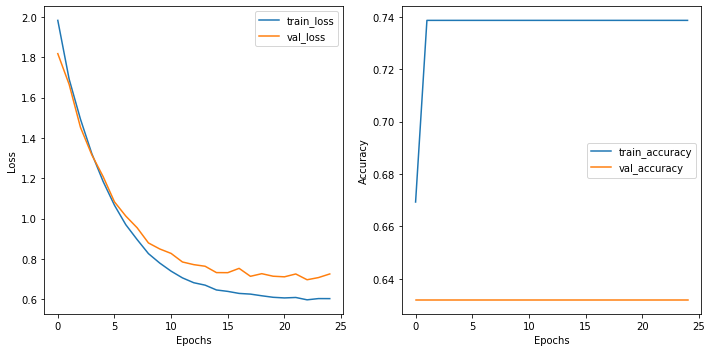

In [73]:
plot_metrics(model_5_results)

Let's try adding adjusting regularization, see if a lower strength is better. Removed from inner layers, decreased strength on input and output layers.

# Model #6

In [105]:
model_6 = Sequential()

model_6.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_6.add(MaxPooling2D(pool_size=(2,2)))

model_6.add(Conv2D(128, (3, 3), activation='relu'))
model_6.add(MaxPooling2D(pool_size=(2,2)))

model_6.add(Conv2D(64, (3, 3), activation='relu'))
model_6.add(MaxPooling2D(pool_size=(2,2)))

model_6.add(Flatten())
model_6.add(Dense(64, activation='relu'))
model_6.add(Dense(32, activation='relu'))
model_6.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_6.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2304)             

In [106]:
model_6_results = model_6.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 3s 864ms/step - loss: 0.6500 - accuracy: 0.7147 - precision: 0.2353 - recall: 0.0320 - val_loss: 0.6964 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
4/4 [==============================] - 2s 489ms/step - loss: 0.5935 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6545 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 [==============================] - 2s 503ms/step - loss: 0.5902 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6856 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
4/4 [==============================] - 2s 492ms/step - loss: 0.5836 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6748 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
4/4 [==============================] - 2s 515

In [107]:
evaluate_model(model_6)

4/4 [==============================] - 0s 41ms/step - loss: 0.4075 - accuracy: 0.8200 - precision: 0.6452 - recall: 0.7407
Training Loss: 0.443 
Training Accuracy: 0.804 
Training Precision: 0.859 
Training Recall: 0.382
---------------------------
Testing Loss: 0.408 
Testing Accuracy: 0.82 
Testing Precision: 0.645 
Testing Recall: 0.741


This is actually pretty decent. Training accuracy is high at 80%, precision at 85% and recall a little worse at 38%. But testing scores are better, which accuracy at 82%, precision at 65%, and recall at 74%! The loss is kind of all over the place per the below though. 

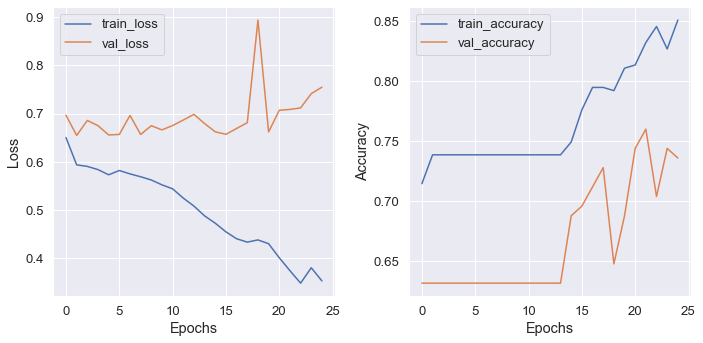

In [108]:
plot_metrics(model_6_results)

# Model #7

Let's try batch normalization. 

In [109]:
model_7 = Sequential()

model_7.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D(pool_size=(2,2)))

model_7.add(Conv2D(128, (3, 3), activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D(pool_size=(2,2)))

model_7.add(Conv2D(64, (3, 3), activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D(pool_size=(2,2)))

model_7.add(Flatten())
model_7.add(Dense(64, activation='relu'))
model_7.add(Dense(32, activation='relu'))
model_7.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_7.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 128)       512       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 12, 12, 64)      

That added more params, let's check it out. 

In [110]:
model_7_results = model_7.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 5s 1s/step - loss: 0.7498 - accuracy: 0.6320 - precision: 0.3604 - recall: 0.3200 - val_loss: 0.6954 - val_accuracy: 0.4240 - val_precision: 0.3646 - val_recall: 0.7609
Epoch 2/25
4/4 [==============================] - 4s 993ms/step - loss: 0.4514 - accuracy: 0.7893 - precision: 0.7111 - recall: 0.3265 - val_loss: 0.7032 - val_accuracy: 0.3600 - val_precision: 0.3455 - val_recall: 0.8261
Epoch 3/25
4/4 [==============================] - 4s 935ms/step - loss: 0.3154 - accuracy: 0.8853 - precision: 0.8986 - recall: 0.6327 - val_loss: 0.7054 - val_accuracy: 0.3760 - val_precision: 0.3431 - val_recall: 0.7609
Epoch 4/25
4/4 [==============================] - 4s 924ms/step - loss: 0.2248 - accuracy: 0.9280 - precision: 0.9494 - recall: 0.7653 - val_loss: 0.6952 - val_accuracy: 0.4960 - val_precision: 0.2821 - val_recall: 0.2391
Epoch 5/25
4/4 [==============================] - 4s 1s/step - loss: 0.1471 - accuracy: 0.9627 - precision: 0.9667 

In [111]:
evaluate_model(model_7)

4/4 [==============================] - 0s 39ms/step - loss: 0.9062 - accuracy: 0.7300 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.01 
Training Accuracy: 0.712 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 0.906 
Testing Accuracy: 0.73 
Testing Precision: 0.0 
Testing Recall: 0.0


Interesting. Batch normalization kind of erased precision and recall. Let's try removing 2 of the 3 batch normalizers and see if it's still bad. 

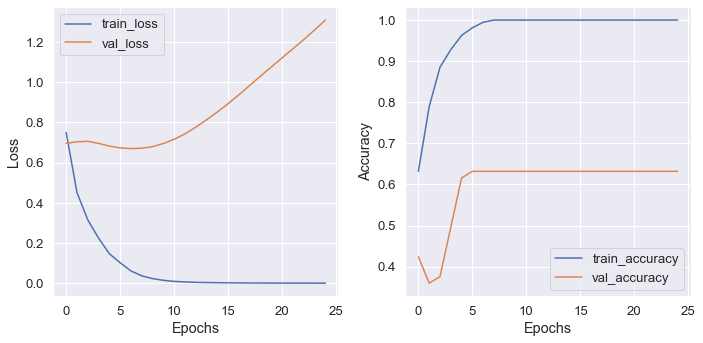

In [112]:
plot_metrics(model_7_results)

# Model #8

In [113]:
model_8 = Sequential()

model_8.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D(pool_size=(2,2)))

model_8.add(Conv2D(128, (3, 3), activation='relu'))
model_8.add(MaxPooling2D(pool_size=(2,2)))

model_8.add(Conv2D(64, (3, 3), activation='relu'))
model_8.add(MaxPooling2D(pool_size=(2,2)))

model_8.add(Flatten())
model_8.add(Dense(64, activation='relu'))
model_8.add(Dense(32, activation='relu'))
model_8.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_8.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 6, 6, 64)        

In [114]:
model_8_results = model_8.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 5s 1s/step - loss: 0.6218 - accuracy: 0.7173 - precision: 0.4000 - recall: 0.1280 - val_loss: 0.6852 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
4/4 [==============================] - 3s 782ms/step - loss: 0.5829 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6840 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 [==============================] - 3s 854ms/step - loss: 0.5604 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6846 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
4/4 [==============================] - 3s 676ms/step - loss: 0.5542 - accuracy: 0.7600 - precision: 0.9000 - recall: 0.0918 - val_loss: 0.6837 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
4/4 [==============================] - 3s 662ms/step - l

In [115]:
evaluate_model(model_8)

4/4 [==============================] - 0s 43ms/step - loss: 0.5376 - accuracy: 0.7600 - precision: 1.0000 - recall: 0.1111
Training Loss: 0.534 
Training Accuracy: 0.728 
Training Precision: 1.0 
Training Recall: 0.0556
---------------------------
Testing Loss: 0.538 
Testing Accuracy: 0.76 
Testing Precision: 1.0 
Testing Recall: 0.111


That improved precision, but not really recall. We want to increase recall. Scores are also kind of decreasing, so we need to add some complexity back in. 

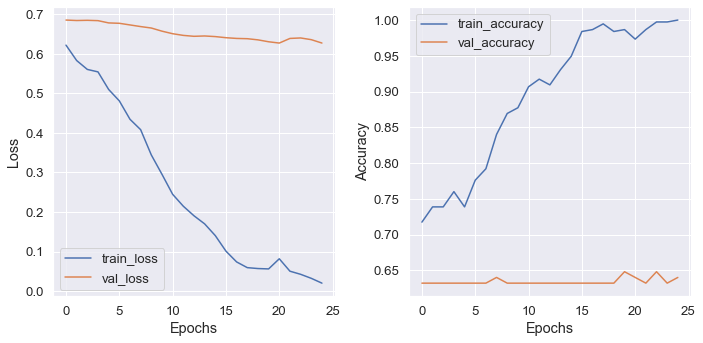

In [116]:
plot_metrics(model_8_results)

# Model #9

Let's remove batch normalization, and play around with the different activation functions. Let's try tanh and then sigmoid and compare to the relu results. Let's use model 6 as our play thing since that had pretty decent results. 

In [121]:
model_9 = Sequential()

model_9.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_9.add(MaxPooling2D(pool_size=(2,2)))

model_9.add(Conv2D(128, (3, 3), activation='tanh'))
model_9.add(MaxPooling2D(pool_size=(2,2)))

model_9.add(Conv2D(64, (3, 3), activation='tanh'))
model_9.add(MaxPooling2D(pool_size=(2,2)))

model_9.add(Flatten())
model_9.add(Dense(64, activation='tanh'))
model_9.add(Dense(32, activation='tanh'))
model_9.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_9.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 2304)            

More params!

In [122]:
model_9_results = model_9.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 3s 792ms/step - loss: 0.6184 - accuracy: 0.7147 - precision: 0.3182 - recall: 0.0560 - val_loss: 0.7324 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
4/4 [==============================] - 2s 518ms/step - loss: 0.5882 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6382 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 [==============================] - 2s 539ms/step - loss: 0.5813 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6878 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
4/4 [==============================] - 2s 526ms/step - loss: 0.5632 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6394 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
4/4 [==============================] - 2s 500

In [123]:
evaluate_model(model_9)

4/4 [==============================] - 0s 33ms/step - loss: 0.5994 - accuracy: 0.7600 - precision: 0.6667 - recall: 0.2222
Training Loss: 0.254 
Training Accuracy: 0.924 
Training Precision: 1.0 
Training Recall: 0.736
---------------------------
Testing Loss: 0.599 
Testing Accuracy: 0.76 
Testing Precision: 0.667 
Testing Recall: 0.222


That increased training accuracy, it's pretty overfit. Precision is higher than recall for the test, maybe not the best model. 

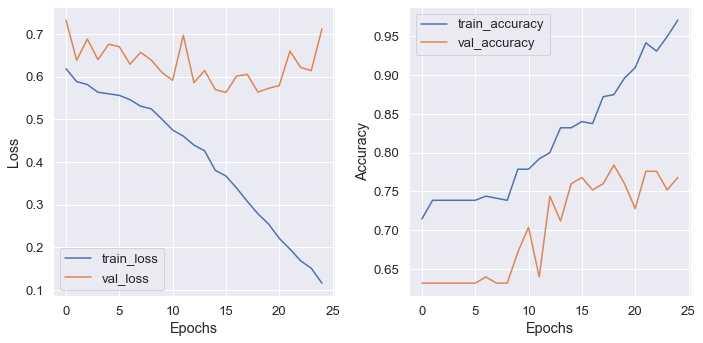

In [124]:
plot_metrics(model_9_results)

# Model #10

Same thing with sigmoid instead.

In [125]:
model_10 = Sequential()

model_10.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='sigmoid', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_10.add(MaxPooling2D(pool_size=(2,2)))

model_10.add(Conv2D(128, (3, 3), activation='sigmoid'))
model_10.add(MaxPooling2D(pool_size=(2,2)))

model_10.add(Conv2D(64, (3, 3), activation='sigmoid'))
model_10.add(MaxPooling2D(pool_size=(2,2)))

model_10.add(Flatten())
model_10.add(Dense(64, activation='sigmoid'))
model_10.add(Dense(32, activation='sigmoid'))
model_10.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_10.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_10.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 2304)            

In [126]:
model_10_results = model_10.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 1s 249ms/step - loss: 0.5774 - accuracy: 0.7387 - precision: 0.6667 - recall: 0.0480 - val_loss: 0.7216 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
4/4 [==============================] - 1s 178ms/step - loss: 0.5821 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.7114 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 [==============================] - 2s 480ms/step - loss: 0.5759 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6893 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
4/4 [==============================] - 2s 567ms/step - loss: 0.5749 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6746 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
4/4 [==============================] - 2s 492

In [127]:
evaluate_model(model_10)

4/4 [==============================] - 0s 32ms/step - loss: 0.5837 - accuracy: 0.7300 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 0.602 
Training Accuracy: 0.712 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 0.584 
Testing Accuracy: 0.73 
Testing Precision: 0.0 
Testing Recall: 0.0


Awesome, the model performs terribly with sigmoid. Let's stick with relu and/or tanh. 

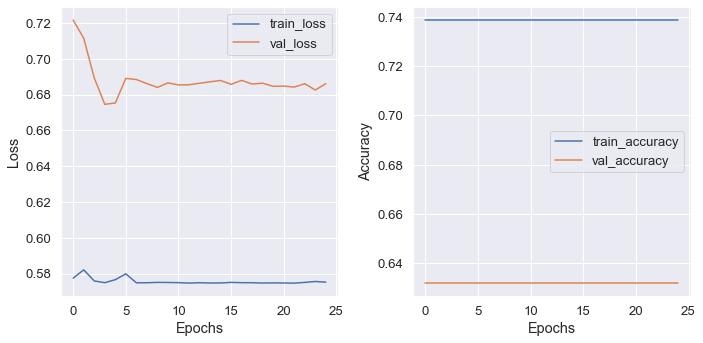

In [128]:
plot_metrics(model_10_results)

# Model #11

Let's try adding in early stopping with model 6 and see if we can get better results. Will use both relu and tanh

In [141]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)

In [142]:
model_11 = Sequential()

model_11.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_11.add(MaxPooling2D(pool_size=(2,2)))

model_11.add(Conv2D(128, (3, 3), activation='relu'))
model_11.add(MaxPooling2D(pool_size=(2,2)))

model_11.add(Conv2D(64, (3, 3), activation='relu'))
model_11.add(MaxPooling2D(pool_size=(2,2)))

model_11.add(Flatten())
model_11.add(Dense(64, activation='relu'))
model_11.add(Dense(32, activation='relu'))
model_11.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_11.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_11.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 2304)            

In [143]:
model_11_results = model_11.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              callbacks=early_stop)

Epoch 1/25
4/4 [==============================] - 1s 249ms/step - loss: 0.6239 - accuracy: 0.7333 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.8874 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
4/4 [==============================] - 1s 166ms/step - loss: 0.6256 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6530 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 [==============================] - 1s 164ms/step - loss: 0.6197 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6566 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
4/4 [==============================] - 1s 180ms/step - loss: 0.6062 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6590 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
4/4 [==============================] 

In [144]:
evaluate_model(model_11)

4/4 [==============================] - 0s 12ms/step - loss: 0.6038 - accuracy: 0.7300 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 0.622 
Training Accuracy: 0.712 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 0.604 
Testing Accuracy: 0.73 
Testing Precision: 0.0 
Testing Recall: 0.0


There goes precision and recall again. Let's see it with tanh.

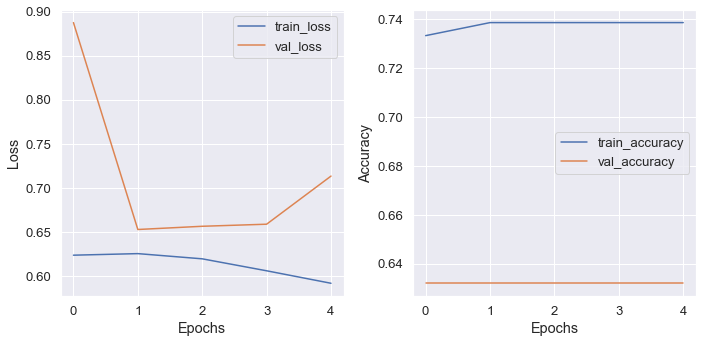

In [145]:
plot_metrics(model_11_results)

# Model #12

In [146]:
model_12 = Sequential()

model_12.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_12.add(MaxPooling2D(pool_size=(2,2)))

model_12.add(Conv2D(128, (3, 3), activation='tanh'))
model_12.add(MaxPooling2D(pool_size=(2,2)))

model_12.add(Conv2D(64, (3, 3), activation='tanh'))
model_12.add(MaxPooling2D(pool_size=(2,2)))

model_12.add(Flatten())
model_12.add(Dense(64, activation='tanh'))
model_12.add(Dense(32, activation='tanh'))
model_12.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_12.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_12.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 2304)            

In [147]:
model_12_results = model_12.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25, 
                              callbacks=early_stop)

Epoch 1/25
4/4 [==============================] - 2s 597ms/step - loss: 0.6332 - accuracy: 0.6320 - precision: 0.2619 - recall: 0.1760 - val_loss: 0.7160 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
4/4 [==============================] - 2s 423ms/step - loss: 0.5936 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6865 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 [==============================] - 2s 463ms/step - loss: 0.5768 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6607 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
4/4 [==============================] - 2s 466ms/step - loss: 0.5659 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6430 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
4/4 [==============================] - 2s 456

In [148]:
evaluate_model(model_12)

4/4 [==============================] - 0s 31ms/step - loss: 0.4602 - accuracy: 0.8000 - precision: 0.6000 - recall: 0.7778
Training Loss: 0.422 
Training Accuracy: 0.816 
Training Precision: 0.745 
Training Recall: 0.549
---------------------------
Testing Loss: 0.46 
Testing Accuracy: 0.8 
Testing Precision: 0.6 
Testing Recall: 0.778


This is not too bad! training accuracy at 82%, precision at 75% and recall is lower at 55%. But test scores are good with accuracy at 80%, precision at 60%, and recall at 78%. The loss is still all over the place, let's try and smooth that out. I think relu results were slightly better all around so we'll stick with relu for now. Will grid search later on.

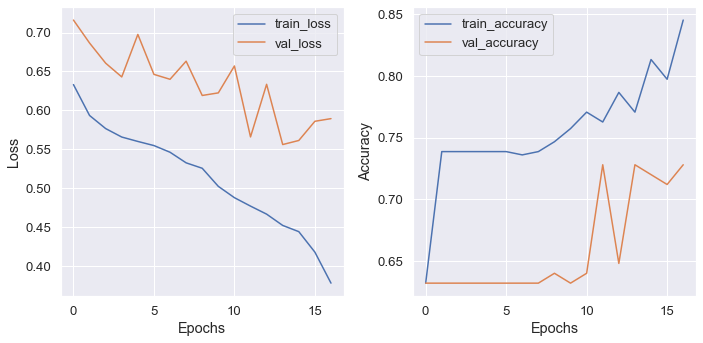

In [149]:
plot_metrics(model_12_results)

# Model #13

Let's adjust the class weights - we have an imbalance, could help balance out the results. 

In [169]:
#y_ints = [y.argmax() for y in binary_train_labels]
class_weights = compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(binary_train_labels),
                                                  y=binary_train_labels)

# turn into dict so it can be put in the fit statement
class_weights_dict = {class_index: weight for class_index, weight in enumerate(class_weights)}

In [170]:
# seems okay, class 1 had the smaller distribution
class_weights_dict

{0: 0.702247191011236, 1: 1.7361111111111112}

In [171]:
model_13 = Sequential()

model_13.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_13.add(MaxPooling2D(pool_size=(2,2)))

model_13.add(Conv2D(128, (3, 3), activation='relu'))
model_13.add(MaxPooling2D(pool_size=(2,2)))

model_13.add(Conv2D(64, (3, 3), activation='relu'))
model_13.add(MaxPooling2D(pool_size=(2,2)))

model_13.add(Flatten())
model_13.add(Dense(64, activation='relu'))
model_13.add(Dense(32, activation='relu'))
model_13.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_13.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_13.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 2304)            

In [172]:
model_13_results = model_13.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25, 
                              class_weight=class_weights_dict)

Epoch 1/25
4/4 [==============================] - 1s 256ms/step - loss: 0.6737 - accuracy: 0.4693 - precision: 0.2694 - recall: 0.4720 - val_loss: 0.6722 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
4/4 [==============================] - 1s 161ms/step - loss: 0.6686 - accuracy: 0.7440 - precision: 1.0000 - recall: 0.0204 - val_loss: 0.6947 - val_accuracy: 0.4640 - val_precision: 0.3793 - val_recall: 0.7174
Epoch 3/25
4/4 [==============================] - 1s 156ms/step - loss: 0.6645 - accuracy: 0.4560 - precision: 0.3080 - recall: 0.8673 - val_loss: 0.6732 - val_accuracy: 0.5760 - val_precision: 0.3939 - val_recall: 0.2826
Epoch 4/25
4/4 [==============================] - 1s 155ms/step - loss: 0.6580 - accuracy: 0.7093 - precision: 0.3514 - recall: 0.1327 - val_loss: 0.6757 - val_accuracy: 0.5120 - val_precision: 0.3684 - val_recall: 0.4565
Epoch 5/25
4/4 [==============================] - 1s 161ms/step - loss: 0.6472 - accuracy: 0.5360 - prec

In [173]:
evaluate_model(model_13)

4/4 [==============================] - 0s 23ms/step - loss: 0.8432 - accuracy: 0.6500 - precision: 0.4333 - recall: 0.9630
Training Loss: 0.371 
Training Accuracy: 0.874 
Training Precision: 0.755 
Training Recall: 0.833
---------------------------
Testing Loss: 0.843 
Testing Accuracy: 0.65 
Testing Precision: 0.433 
Testing Recall: 0.963


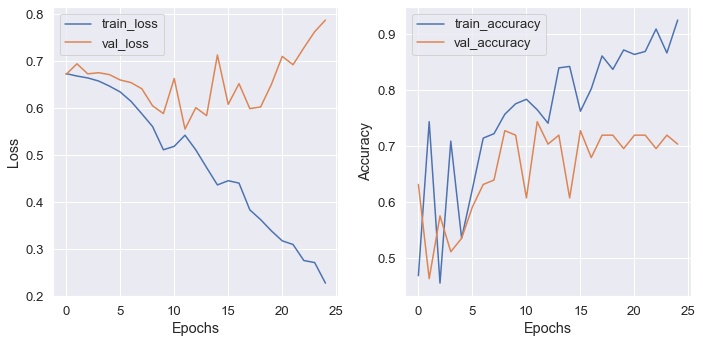

In [174]:
plot_metrics(model_13_results)

Didn't really help the loss function did it.. Helped recall though! Let's add some regularization in for that overfitting. 

# Model #14

Add dropout.

In [175]:
model_14 = Sequential()

model_14.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_14.add(MaxPooling2D(pool_size=(2,2)))
model_14.add(Dropout(0.2))

model_14.add(Conv2D(128, (3, 3), activation='relu'))
model_14.add(MaxPooling2D(pool_size=(2,2)))
model_14.add(Dropout(0.2))

model_14.add(Conv2D(64, (3, 3), activation='relu'))
model_14.add(MaxPooling2D(pool_size=(2,2)))
model_14.add(Dropout(0.2))

model_14.add(Flatten())
model_14.add(Dense(64, activation='relu'))
model_14.add(Dense(32, activation='relu'))
model_14.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_14.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_14.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 12, 12, 64)      

In [176]:
model_14_results = model_14.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
4/4 [==============================] - 1s 278ms/step - loss: 0.6762 - accuracy: 0.5307 - precision: 0.3114 - recall: 0.5680 - val_loss: 0.6850 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
4/4 [==============================] - 1s 197ms/step - loss: 0.6711 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6835 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 [==============================] - 1s 195ms/step - loss: 0.6670 - accuracy: 0.7120 - precision: 0.3077 - recall: 0.0816 - val_loss: 0.6818 - val_accuracy: 0.6480 - val_precision: 0.5357 - val_recall: 0.3261
Epoch 4/25
4/4 [==============================] - 1s 191ms/step - loss: 0.6651 - accuracy: 0.5520 - precision: 0.2917 - recall: 0.5000 - val_loss: 0.6689 - val_accuracy: 0.6320 - val_precision: 0.5000 - val_recall: 0.3043
Epoch 5/25
4/4 [==============================] - 1s 200ms/step - loss: 0.6616 - accurac

In [177]:
evaluate_model(model_14)

4/4 [==============================] - 0s 25ms/step - loss: 0.4090 - accuracy: 0.7600 - precision: 0.5455 - recall: 0.6667
Training Loss: 0.394 
Training Accuracy: 0.846 
Training Precision: 0.802 
Training Recall: 0.618
---------------------------
Testing Loss: 0.409 
Testing Accuracy: 0.76 
Testing Precision: 0.545 
Testing Recall: 0.667


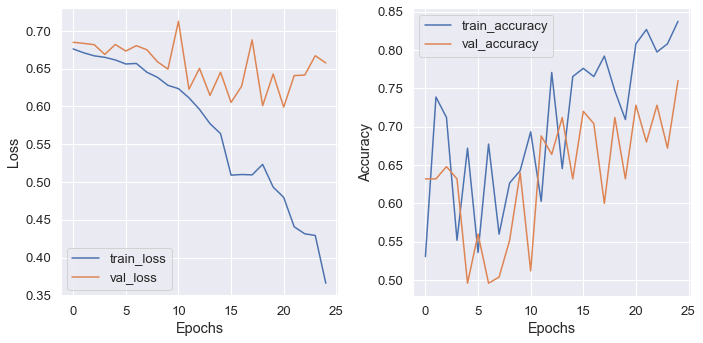

In [178]:
plot_metrics(model_14_results)

Accuracy is all over the place, train loss is better but val loss is still wonky. Let's try different batch sizes and epochs. 

In [ ]:
# use model_14

In [179]:
model_14_loop = {}
batch_sizes = [50, 100, 150]
epochs = [15, 25, 50]

for batch_size in batch_sizes:
    for epoch in epochs:
        model = model_14
        
        model.compile(optimizer='Adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', precision, recall])
        
        # Train the model
        model_results = model.fit(train_images, 
                                  binary_train_labels, 
                                  batch_size=batch_size, 
                                  epochs=epoch,
                                  validation_split=0.25,
                                  class_weight=class_weights_dict)
        
        # Store the results in a dictionary using the combination of batch size and epochs as keys
        model_14_loop[(batch_size, epoch)] = model_results

Epoch 1/15
8/8 [==============================] - 1s 155ms/step - loss: 0.4358 - accuracy: 0.8160 - precision: 0.6013 - recall: 0.7600 - val_loss: 0.7303 - val_accuracy: 0.6800 - val_precision: 0.5536 - val_recall: 0.6739
Epoch 2/15
8/8 [==============================] - 1s 114ms/step - loss: 0.4194 - accuracy: 0.8107 - precision: 0.6174 - recall: 0.7245 - val_loss: 0.6363 - val_accuracy: 0.6800 - val_precision: 0.5625 - val_recall: 0.5870
Epoch 3/15
8/8 [==============================] - 1s 111ms/step - loss: 0.3907 - accuracy: 0.7787 - precision: 0.5455 - recall: 0.9184 - val_loss: 0.6172 - val_accuracy: 0.7520 - val_precision: 0.8261 - val_recall: 0.4130
Epoch 4/15
8/8 [==============================] - 1s 111ms/step - loss: 0.3647 - accuracy: 0.8800 - precision: 0.7789 - recall: 0.7551 - val_loss: 0.7035 - val_accuracy: 0.6560 - val_precision: 0.5273 - val_recall: 0.6304
Epoch 5/15
8/8 [==============================] - 1s 114ms/step - loss: 0.3243 - accuracy: 0.8667 - precision: 0

Epoch 23/25
8/8 [==============================] - 2s 288ms/step - loss: 0.0421 - accuracy: 0.9920 - precision: 0.9897 - recall: 0.9796 - val_loss: 1.6078 - val_accuracy: 0.7440 - val_precision: 0.7059 - val_recall: 0.5217
Epoch 24/25
8/8 [==============================] - 3s 384ms/step - loss: 0.0418 - accuracy: 0.9920 - precision: 0.9703 - recall: 1.0000 - val_loss: 1.8586 - val_accuracy: 0.7600 - val_precision: 0.7667 - val_recall: 0.5000
Epoch 25/25
8/8 [==============================] - 3s 348ms/step - loss: 0.0339 - accuracy: 0.9920 - precision: 0.9703 - recall: 1.0000 - val_loss: 1.8557 - val_accuracy: 0.7440 - val_precision: 0.7059 - val_recall: 0.5217
Epoch 1/50
8/8 [==============================] - 3s 344ms/step - loss: 0.0834 - accuracy: 0.9733 - precision: 0.8750 - recall: 0.8264 - val_loss: 1.8943 - val_accuracy: 0.6960 - val_precision: 0.5952 - val_recall: 0.5435
Epoch 2/50
8/8 [==============================] - 2s 263ms/step - loss: 0.0626 - accuracy: 0.9733 - precision

Epoch 35/50
8/8 [==============================] - 2s 274ms/step - loss: 0.0032 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.5962 - val_accuracy: 0.7440 - val_precision: 0.7059 - val_recall: 0.5217
Epoch 36/50
8/8 [==============================] - 2s 257ms/step - loss: 0.0046 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.7236 - val_accuracy: 0.7360 - val_precision: 0.7097 - val_recall: 0.4783
Epoch 37/50
8/8 [==============================] - 2s 252ms/step - loss: 0.0027 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.9042 - val_accuracy: 0.7280 - val_precision: 0.7308 - val_recall: 0.4130
Epoch 38/50
8/8 [==============================] - 2s 258ms/step - loss: 0.0037 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.8367 - val_accuracy: 0.7360 - val_precision: 0.7241 - val_recall: 0.4565
Epoch 39/50
8/8 [==============================] - 2s 244ms/step - loss: 0.0041 - accuracy: 1.0000 - precisi

Epoch 7/25
4/4 [==============================] - 2s 396ms/step - loss: 0.0144 - accuracy: 0.9947 - precision: 1.0000 - recall: 0.9796 - val_loss: 3.1516 - val_accuracy: 0.7280 - val_precision: 0.6667 - val_recall: 0.5217
Epoch 8/25
4/4 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9920 - precision: 0.9703 - recall: 1.000 - 2s 394ms/step - loss: 0.0175 - accuracy: 0.9920 - precision: 0.9703 - recall: 1.0000 - val_loss: 3.3674 - val_accuracy: 0.7200 - val_precision: 0.6667 - val_recall: 0.4783
Epoch 9/25
4/4 [==============================] - 2s 423ms/step - loss: 0.0509 - accuracy: 0.9973 - precision: 1.0000 - recall: 0.9898 - val_loss: 3.4397 - val_accuracy: 0.7360 - val_precision: 0.7600 - val_recall: 0.4130
Epoch 10/25
4/4 [==============================] - 2s 473ms/step - loss: 0.0030 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.0644 - val_accuracy: 0.7040 - val_precision: 0.6364 - val_recall: 0.4565
Epoch 11/25
4/4 [==============

4/4 [==============================] - 2s 443ms/step - loss: 0.0011 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.8872 - val_accuracy: 0.7120 - val_precision: 0.6923 - val_recall: 0.3913
Epoch 19/50
4/4 [==============================] - 2s 434ms/step - loss: 0.0010 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.1358 - val_accuracy: 0.7200 - val_precision: 0.7200 - val_recall: 0.3913
Epoch 20/50
4/4 [==============================] - 2s 403ms/step - loss: 0.0014 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.1378 - val_accuracy: 0.7040 - val_precision: 0.6800 - val_recall: 0.3696
Epoch 21/50
4/4 [==============================] - 2s 431ms/step - loss: 6.5663e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.1121 - val_accuracy: 0.6880 - val_precision: 0.6296 - val_recall: 0.3696
Epoch 22/50
4/4 [==============================] - 2s 459ms/step - loss: 6.4257e-04 - accuracy: 1.0000 - precision: 

3/3 [==============================] - 1s 480ms/step - loss: 8.0402e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.6566 - val_accuracy: 0.6960 - val_precision: 0.6333 - val_recall: 0.4130
Epoch 5/15
3/3 [==============================] - 1s 500ms/step - loss: 0.0014 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.2376 - val_accuracy: 0.7120 - val_precision: 0.6562 - val_recall: 0.4565
Epoch 6/15
3/3 [==============================] - 1s 500ms/step - loss: 0.0042 - accuracy: 0.9973 - precision: 0.9899 - recall: 1.0000 - val_loss: 4.3232 - val_accuracy: 0.7280 - val_precision: 0.7143 - val_recall: 0.4348
Epoch 7/15
3/3 [==============================] - 1s 482ms/step - loss: 0.0014 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.6312 - val_accuracy: 0.7200 - val_precision: 0.7391 - val_recall: 0.3696
Epoch 8/15
3/3 [==============================] - 1s 467ms/step - loss: 0.0268 - accuracy: 0.9947 - precision: 0.9898 -

Epoch 1/50
3/3 [==============================] - 3s 897ms/step - loss: 0.0011 - accuracy: 1.0000 - precision: 0.8939 - recall: 0.8194 - val_loss: 4.9774 - val_accuracy: 0.7120 - val_precision: 0.7500 - val_recall: 0.3261
Epoch 2/50
3/3 [==============================] - 1s 430ms/step - loss: 0.0011 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.9002 - val_accuracy: 0.6720 - val_precision: 0.5806 - val_recall: 0.3913
Epoch 3/50
3/3 [==============================] - 2s 529ms/step - loss: 8.0597e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.2937 - val_accuracy: 0.6800 - val_precision: 0.6000 - val_recall: 0.3913
Epoch 4/50
3/3 [==============================] - 2s 686ms/step - loss: 0.0011 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 5.3058 - val_accuracy: 0.6800 - val_precision: 0.6000 - val_recall: 0.3913
Epoch 5/50
3/3 [==============================] - 2s 754ms/step - loss: 0.0012 - accuracy: 1.0000 - precisio

3/3 [==============================] - 2s 701ms/step - loss: 0.0031 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.9618 - val_accuracy: 0.6880 - val_precision: 0.6061 - val_recall: 0.4348
Epoch 38/50
3/3 [==============================] - 2s 524ms/step - loss: 0.0118 - accuracy: 0.9973 - precision: 0.9899 - recall: 1.0000 - val_loss: 3.8400 - val_accuracy: 0.6800 - val_precision: 0.5833 - val_recall: 0.4565
Epoch 39/50
3/3 [==============================] - 2s 541ms/step - loss: 0.0025 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.8206 - val_accuracy: 0.6800 - val_precision: 0.5882 - val_recall: 0.4348
Epoch 40/50
3/3 [==============================] - 2s 522ms/step - loss: 0.0148 - accuracy: 0.9973 - precision: 0.9899 - recall: 1.0000 - val_loss: 3.8926 - val_accuracy: 0.6880 - val_precision: 0.6129 - val_recall: 0.4130
Epoch 41/50
3/3 [==============================] - 1s 491ms/step - loss: 0.0013 - accuracy: 1.0000 - precision: 1.0000 -

In [180]:
average_accuracy = {}

for batch_size in batch_sizes:
    for epoch in epochs:
        history = model_14_loop[(batch_size, epoch)].history
        avg_acc = sum(history['accuracy']) / len(history['accuracy'])
        average_accuracy[(batch_size, epoch)] = avg_acc

for batch_size in batch_sizes:
    for epoch in epochs:
        print(f"Batch Size {batch_size}, Epochs {epoch}:")
        print(f"Average Accuracy: {average_accuracy[(batch_size, epoch)]}")

Batch Size 50, Epochs 15:
Average Accuracy: 0.8752000013987223
Batch Size 50, Epochs 25:
Average Accuracy: 0.9661866641044616
Batch Size 50, Epochs 50:
Average Accuracy: 0.9918933391571045
Batch Size 100, Epochs 15:
Average Accuracy: 0.9968000054359436
Batch Size 100, Epochs 25:
Average Accuracy: 0.9968000078201293
Batch Size 100, Epochs 50:
Average Accuracy: 0.9976533365249634
Batch Size 150, Epochs 15:
Average Accuracy: 0.9982222278912862
Batch Size 150, Epochs 25:
Average Accuracy: 0.9990400052070618
Batch Size 150, Epochs 50:
Average Accuracy: 0.9984533405303955


Let's try batch size 50 and both 15 and 25 epochs. Everything else looks like it will overfit. 

# Model #15

In [181]:
model_15 = Sequential()

model_15.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_15.add(MaxPooling2D(pool_size=(2,2)))
model_15.add(Dropout(0.2))

model_15.add(Conv2D(128, (3, 3), activation='relu'))
model_15.add(MaxPooling2D(pool_size=(2,2)))
model_15.add(Dropout(0.2))

model_15.add(Conv2D(64, (3, 3), activation='relu'))
model_15.add(MaxPooling2D(pool_size=(2,2)))
model_15.add(Dropout(0.2))

model_15.add(Flatten())
model_15.add(Dense(64, activation='relu'))
model_15.add(Dense(32, activation='relu'))
model_15.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_15.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_15.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 12, 12, 64)      

In [182]:
# try batch size 50 and 15 epochs first
model_15_results = model_15.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=15,
                              class_weight=class_weights_dict)

Epoch 1/15
8/8 [==============================] - 1s 171ms/step - loss: 0.6718 - accuracy: 0.6400 - precision: 0.3504 - recall: 0.2847 - val_loss: 0.6678 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
8/8 [==============================] - 1s 129ms/step - loss: 0.6695 - accuracy: 0.5840 - precision: 0.2315 - recall: 0.2551 - val_loss: 0.6658 - val_accuracy: 0.6240 - val_precision: 0.4000 - val_recall: 0.0435
Epoch 3/15
8/8 [==============================] - 1s 122ms/step - loss: 0.6740 - accuracy: 0.5787 - precision: 0.2761 - recall: 0.3776 - val_loss: 0.7021 - val_accuracy: 0.4480 - val_precision: 0.3736 - val_recall: 0.7391
Epoch 4/15
8/8 [==============================] - 1s 114ms/step - loss: 0.6632 - accuracy: 0.5547 - precision: 0.3115 - recall: 0.5816 - val_loss: 0.6686 - val_accuracy: 0.6400 - val_precision: 0.5556 - val_recall: 0.1087
Epoch 5/15
8/8 [==============================] - 1s 122ms/step - loss: 0.6598 - accuracy: 0.6640 - prec

In [183]:
evaluate_model(model_15)

4/4 [==============================] - 0s 23ms/step - loss: 1.1780 - accuracy: 0.4300 - precision: 0.3214 - recall: 1.0000
Training Loss: 0.509 
Training Accuracy: 0.778 
Training Precision: 0.58 
Training Recall: 0.833
---------------------------
Testing Loss: 1.18 
Testing Accuracy: 0.43 
Testing Precision: 0.321 
Testing Recall: 1.0


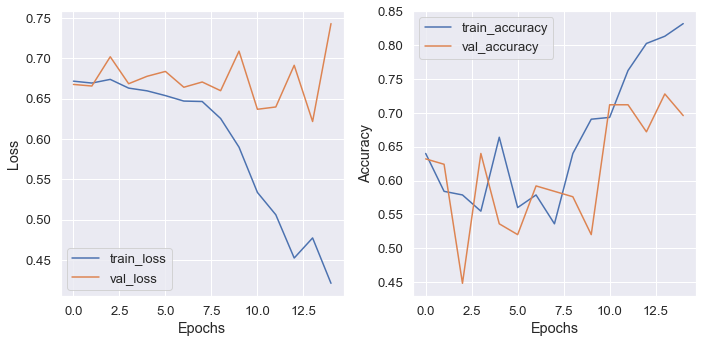

In [184]:
plot_metrics(model_15_results)

Not great - let's try 25 epochs now.

In [185]:
model_15_results = model_15.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 1s 118ms/step - loss: 0.3911 - accuracy: 0.8187 - precision: 0.6119 - recall: 0.8367 - val_loss: 0.7517 - val_accuracy: 0.7280 - val_precision: 0.8000 - val_recall: 0.3478
Epoch 2/25
8/8 [==============================] - 1s 172ms/step - loss: 0.3737 - accuracy: 0.8533 - precision: 0.6838 - recall: 0.8163 - val_loss: 0.6588 - val_accuracy: 0.7200 - val_precision: 0.6571 - val_recall: 0.5000
Epoch 3/25
8/8 [==============================] - 3s 385ms/step - loss: 0.3404 - accuracy: 0.8400 - precision: 0.6583 - recall: 0.8061 - val_loss: 0.7491 - val_accuracy: 0.7200 - val_precision: 0.6170 - val_recall: 0.6304
Epoch 4/25
8/8 [==============================] - 3s 420ms/step - loss: 0.2785 - accuracy: 0.8853 - precision: 0.7273 - recall: 0.8980 - val_loss: 0.8142 - val_accuracy: 0.7120 - val_precision: 0.6087 - val_recall: 0.6087
Epoch 5/25
8/8 [==============================] - 3s 399ms/step - loss: 0.2861 - accuracy: 0.8773 - precision: 0

In [186]:
evaluate_model(model_15)

4/4 [==============================] - 0s 42ms/step - loss: 1.6774 - accuracy: 0.6000 - precision: 0.3860 - recall: 0.8148
Training Loss: 0.417 
Training Accuracy: 0.926 
Training Precision: 0.885 
Training Recall: 0.854
---------------------------
Testing Loss: 1.68 
Testing Accuracy: 0.6 
Testing Precision: 0.386 
Testing Recall: 0.815


Great training scores, not so great testing scores. This overfit the model - let's try adding some more regularization. 

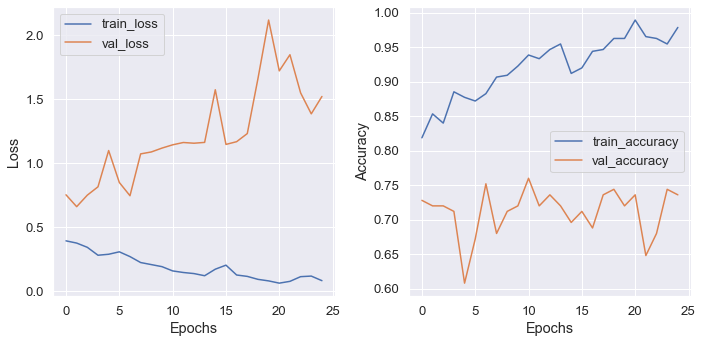

In [187]:
plot_metrics(model_15_results)

# Model #16

In [189]:
model_16 = Sequential()

model_16.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_16.add(MaxPooling2D(pool_size=(2,2)))
model_16.add(Dropout(0.3)) # increased

model_16.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))) # added
model_16.add(MaxPooling2D(pool_size=(2,2)))
model_16.add(Dropout(0.2))

model_16.add(Conv2D(64, (3, 3), activation='relu'))
model_16.add(MaxPooling2D(pool_size=(2,2)))
model_16.add(Dropout(0.2))

model_16.add(Flatten())
model_16.add(Dense(64, activation='relu'))
model_16.add(Dense(32, activation='relu'))
model_16.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_16.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 12, 12, 64)      

In [191]:
model_16_results = model_16.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 1s 168ms/step - loss: 0.6838 - accuracy: 0.7333 - precision: 0.3810 - recall: 0.1920 - val_loss: 0.6859 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
8/8 [==============================] - 1s 116ms/step - loss: 0.6782 - accuracy: 0.5120 - precision: 0.2258 - recall: 0.3571 - val_loss: 0.6963 - val_accuracy: 0.5280 - val_precision: 0.3934 - val_recall: 0.5217
Epoch 3/25
8/8 [==============================] - 1s 112ms/step - loss: 0.6715 - accuracy: 0.7040 - precision: 0.3488 - recall: 0.1531 - val_loss: 0.6770 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
8/8 [==============================] - 1s 114ms/step - loss: 0.6762 - accuracy: 0.7413 - precision: 0.5385 - recall: 0.0714 - val_loss: 0.6879 - val_accuracy: 0.5520 - val_precision: 0.4074 - val_recall: 0.4783
Epoch 5/25
8/8 [==============================] - 1s 113ms/step - loss: 0.6732 - accuracy: 0.450

In [192]:
evaluate_model(model_16)

4/4 [==============================] - 0s 32ms/step - loss: 0.5375 - accuracy: 0.7100 - precision: 0.4762 - recall: 0.7407
Training Loss: 0.361 
Training Accuracy: 0.888 
Training Precision: 0.867 
Training Recall: 0.722
---------------------------
Testing Loss: 0.537 
Testing Accuracy: 0.71 
Testing Precision: 0.476 
Testing Recall: 0.741


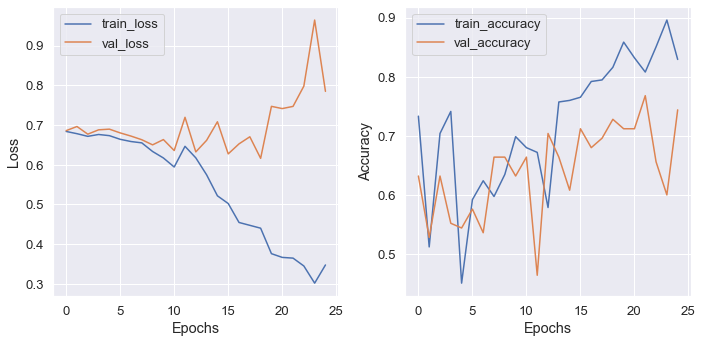

In [193]:
plot_metrics(model_16_results)

# Model #17

Let's try adjusting the numbers of units in each of the layers. Start by doubling them all. 

In [204]:
model_17 = Sequential()

model_17.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_17.add(MaxPooling2D(pool_size=(2,2)))
model_17.add(Dropout(0.3)) # increased

model_17.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))) # added
model_17.add(MaxPooling2D(pool_size=(2,2)))
model_17.add(Dropout(0.2))

model_17.add(Conv2D(128, (3, 3), activation='relu'))
model_17.add(MaxPooling2D(pool_size=(2,2)))
model_17.add(Dropout(0.2))

model_17.add(Flatten())
model_17.add(Dense(128, activation='relu'))
model_17.add(Dense(64, activation='relu'))
model_17.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_17.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_17.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 12, 12, 128)     

In [205]:
model_17_results = model_17.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 3s 369ms/step - loss: 0.6851 - accuracy: 0.6533 - precision: 0.2956 - recall: 0.3760 - val_loss: 0.6898 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
8/8 [==============================] - 2s 300ms/step - loss: 0.6788 - accuracy: 0.6453 - precision: 0.2388 - recall: 0.1633 - val_loss: 0.6748 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
8/8 [==============================] - 2s 297ms/step - loss: 0.6813 - accuracy: 0.5280 - precision: 0.2768 - recall: 0.5000 - val_loss: 0.6938 - val_accuracy: 0.4800 - val_precision: 0.3662 - val_recall: 0.5652
Epoch 4/25
8/8 [==============================] - 4s 475ms/step - loss: 0.6717 - accuracy: 0.6533 - precision: 0.3140 - recall: 0.2755 - val_loss: 0.6789 - val_accuracy: 0.6160 - val_precision: 0.4545 - val_recall: 0.2174
Epoch 5/25
8/8 [==============================] - 5s 611ms/step - loss: 0.6654 - accuracy: 0.576

In [206]:
evaluate_model(model_17)

4/4 [==============================] - 0s 91ms/step - loss: 1.9433 - accuracy: 0.4500 - precision: 0.3250 - recall: 0.9630
Training Loss: 0.498 
Training Accuracy: 0.854 
Training Precision: 0.692 
Training Recall: 0.889
---------------------------
Testing Loss: 1.94 
Testing Accuracy: 0.45 
Testing Precision: 0.325 
Testing Recall: 0.963


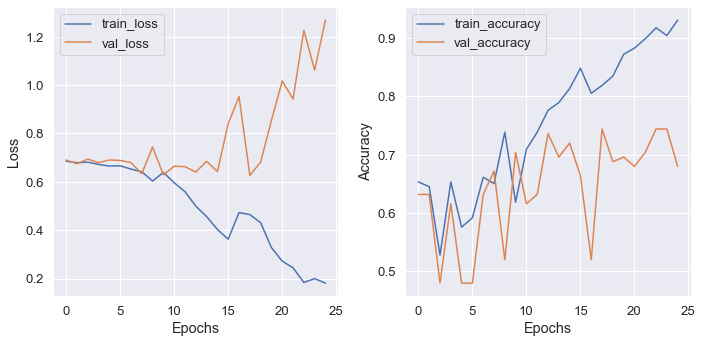

In [207]:
plot_metrics(model_17_results)

Let's try halving them instead. 

# Model #18

In [208]:
model_18 = Sequential()

model_18.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_18.add(MaxPooling2D(pool_size=(2,2)))
model_18.add(Dropout(0.3))

model_18.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))) # added
model_18.add(MaxPooling2D(pool_size=(2,2)))
model_18.add(Dropout(0.2))

model_18.add(Conv2D(32, (3, 3), activation='relu'))
model_18.add(MaxPooling2D(pool_size=(2,2)))
model_18.add(Dropout(0.2))

model_18.add(Flatten())
model_18.add(Dense(32, activation='relu'))
model_18.add(Dense(16, activation='relu'))
model_18.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_18.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_18.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 12, 12, 32)      

In [209]:
model_18_results = model_18.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 3s 360ms/step - loss: 0.6793 - accuracy: 0.6267 - precision: 0.2785 - recall: 0.3520 - val_loss: 0.6855 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
8/8 [==============================] - 2s 276ms/step - loss: 0.6741 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6828 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
8/8 [==============================] - 3s 336ms/step - loss: 0.6730 - accuracy: 0.6960 - precision: 0.2333 - recall: 0.0714 - val_loss: 0.6805 - val_accuracy: 0.6400 - val_precision: 0.5263 - val_recall: 0.2174
Epoch 4/25
8/8 [==============================] - 2s 305ms/step - loss: 0.6650 - accuracy: 0.5840 - precision: 0.2958 - recall: 0.4286 - val_loss: 0.6890 - val_accuracy: 0.4800 - val_precision: 0.3699 - val_recall: 0.5870
Epoch 5/25
8/8 [==============================] - 2s 297ms/step - loss: 0.6619 - accurac

In [210]:
evaluate_model(model_18)

4/4 [==============================] - 0s 33ms/step - loss: 0.6535 - accuracy: 0.5900 - precision: 0.3750 - recall: 0.7778
Training Loss: 0.496 
Training Accuracy: 0.802 
Training Precision: 0.63 
Training Recall: 0.757
---------------------------
Testing Loss: 0.654 
Testing Accuracy: 0.59 
Testing Precision: 0.375 
Testing Recall: 0.778


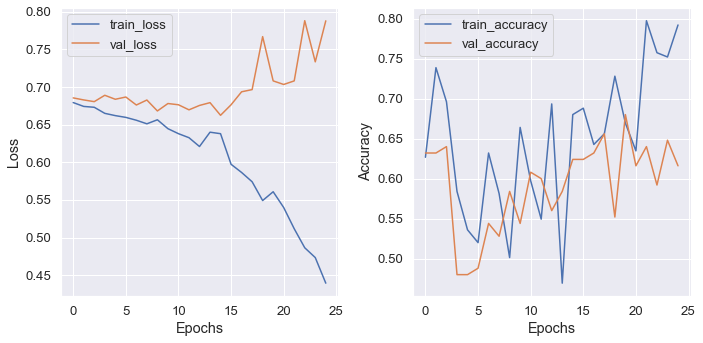

In [211]:
plot_metrics(model_18_results)

That was worse! Let's go back to the original units, and add more dense layers in between to connect the neurons. 

# Model #19

In [214]:
model_19 = Sequential()

model_19.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_19.add(Dense(64, activation='relu')) # added
model_19.add(MaxPooling2D(pool_size=(2,2)))
model_19.add(Dropout(0.3))

model_19.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model_19.add(Dense(64, activation='relu'))
model_19.add(MaxPooling2D(pool_size=(2,2)))
model_19.add(Dropout(0.2))

model_19.add(Conv2D(64, (3, 3), activation='relu'))
model_19.add(Dense(64, activation='relu'))
model_19.add(MaxPooling2D(pool_size=(2,2)))
model_19.add(Dropout(0.2))

model_19.add(Flatten())
model_19.add(Dense(64, activation='relu'))
model_19.add(Dense(32, activation='relu'))
model_19.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_19.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_19.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 62, 62, 32)        320       
_________________________________________________________________
dense_108 (Dense)            (None, 62, 62, 64)        2112      
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 29, 29, 128)       73856     
_________________________________________________________________
dense_109 (Dense)            (None, 29, 29, 64)        8256      
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 14, 14, 64)      

In [215]:
model_19_results = model_19.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 6s 760ms/step - loss: 0.6890 - accuracy: 0.7093 - precision: 0.3288 - recall: 0.1920 - val_loss: 0.6973 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
8/8 [==============================] - 5s 578ms/step - loss: 0.6798 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6919 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
8/8 [==============================] - 5s 582ms/step - loss: 0.6794 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6822 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
8/8 [==============================] - 5s 574ms/step - loss: 0.6758 - accuracy: 0.7387 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6885 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
8/8 [==============================] - 5s 578

In [216]:
evaluate_model(model_19)

4/4 [==============================] - 0s 77ms/step - loss: 0.9813 - accuracy: 0.5400 - precision: 0.3623 - recall: 0.9259
Training Loss: 0.505 
Training Accuracy: 0.792 
Training Precision: 0.603 
Training Recall: 0.812
---------------------------
Testing Loss: 0.981 
Testing Accuracy: 0.54 
Testing Precision: 0.362 
Testing Recall: 0.926


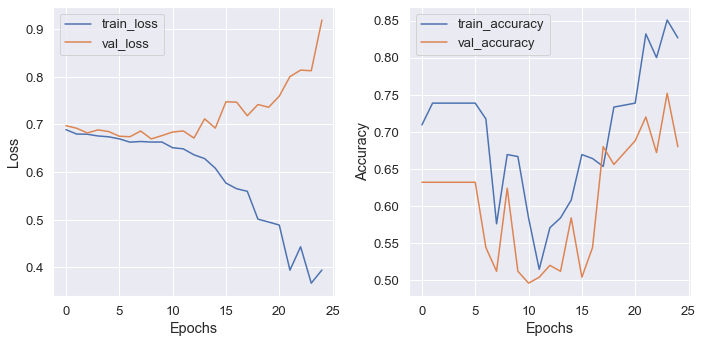

In [217]:
plot_metrics(model_19_results)

I think I need to add batch normalization in again. 

# Model #20

Going back to model 12 as that was decent results. Adding in batch normalization to try and stablize loss/accuracy.

In [222]:
model_20 = Sequential()

model_20.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_20.add(MaxPooling2D(pool_size=(2,2)))
model_20.add(Dropout(0.3))

model_20.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model_20.add(MaxPooling2D(pool_size=(2,2)))
model_20.add(Dropout(0.2))

model_20.add(Conv2D(64, (3, 3), activation='relu'))
model_20.add(BatchNormalization())
model_20.add(MaxPooling2D(pool_size=(2,2)))
model_20.add(Dropout(0.1))

model_20.add(Flatten())
model_20.add(Dense(128, activation='relu'))
model_20.add(Dense(64, activation='relu'))
model_20.add(Dense(32, activation='relu'))
model_20.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_20.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_20.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 12, 12, 64)      

In [224]:
model_20_results = model_20.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 2s 251ms/step - loss: 0.7160 - accuracy: 0.4507 - precision: 0.2429 - recall: 0.4080 - val_loss: 0.6930 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
8/8 [==============================] - 3s 357ms/step - loss: 0.6740 - accuracy: 0.5733 - precision: 0.3368 - recall: 0.6531 - val_loss: 0.6900 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
8/8 [==============================] - 3s 395ms/step - loss: 0.6332 - accuracy: 0.6453 - precision: 0.3741 - recall: 0.5306 - val_loss: 0.6945 - val_accuracy: 0.6240 - val_precision: 0.4545 - val_recall: 0.1087
Epoch 4/25
8/8 [==============================] - 3s 330ms/step - loss: 0.6164 - accuracy: 0.6160 - precision: 0.3814 - recall: 0.7551 - val_loss: 0.6880 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
8/8 [==============================] - 3s 360ms/step - loss: 0.5635 - accurac

In [225]:
evaluate_model(model_20)

4/4 [==============================] - 0s 29ms/step - loss: 0.4787 - accuracy: 0.8000 - precision: 0.8182 - recall: 0.3333
Training Loss: 0.31 
Training Accuracy: 0.904 
Training Precision: 0.971 
Training Recall: 0.688
---------------------------
Testing Loss: 0.479 
Testing Accuracy: 0.8 
Testing Precision: 0.818 
Testing Recall: 0.333


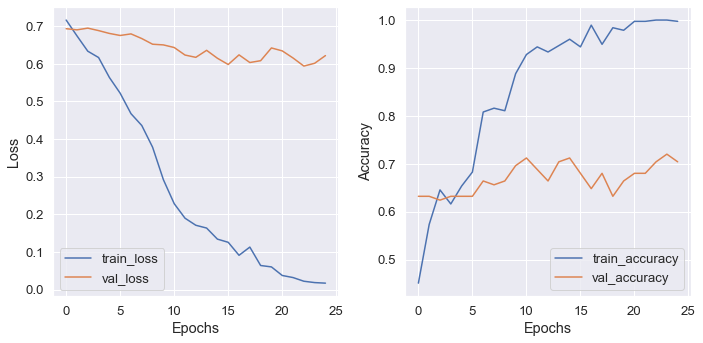

In [226]:
plot_metrics(model_20_results)

Having batch normalization in the end helped with stability, precision > recall now. Want the other way.

# Twenty First Model

increasing regularization, added in another batch normalization. 

In [227]:
model_21 = Sequential()

model_21.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_21.add(MaxPooling2D(pool_size=(2,2)))
model_21.add(Dropout(0.3))

model_21.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model_21.add(BatchNormalization())
model_21.add(MaxPooling2D(pool_size=(2,2)))
model_21.add(Dropout(0.3))

model_21.add(Conv2D(64, (3, 3), activation='relu'))
model_21.add(BatchNormalization())
model_21.add(MaxPooling2D(pool_size=(2,2)))
model_21.add(Dropout(0.2))

model_21.add(Flatten())
model_21.add(Dense(128, activation='relu'))
model_21.add(Dense(64, activation='relu'))
model_21.add(Dense(32, activation='relu'))
model_21.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_21.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_21.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 29, 29, 128)       36992     
_________________________________________________________________
batch_normalization_9 (Batch (None, 29, 29, 128)       512       
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 14, 14, 128)     

In [228]:
model_21_results = model_21.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 6s 725ms/step - loss: 0.8830 - accuracy: 0.4800 - precision: 0.2632 - recall: 0.4000 - val_loss: 0.6960 - val_accuracy: 0.5520 - val_precision: 0.2727 - val_recall: 0.1304
Epoch 2/25
8/8 [==============================] - 4s 493ms/step - loss: 0.6776 - accuracy: 0.5867 - precision: 0.3007 - recall: 0.4388 - val_loss: 0.6733 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
8/8 [==============================] - 4s 445ms/step - loss: 0.6297 - accuracy: 0.5707 - precision: 0.3478 - recall: 0.7347 - val_loss: 0.6668 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
8/8 [==============================] - 4s 502ms/step - loss: 0.6138 - accuracy: 0.6613 - precision: 0.4121 - recall: 0.6939 - val_loss: 0.6937 - val_accuracy: 0.6320 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
8/8 [==============================] - 3s 431ms/step - loss: 0.5561 - accurac

In [229]:
evaluate_model(model_21)

4/4 [==============================] - 0s 43ms/step - loss: 3.1144 - accuracy: 0.7300 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 3.34 
Training Accuracy: 0.712 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 3.11 
Testing Accuracy: 0.73 
Testing Precision: 0.0 
Testing Recall: 0.0


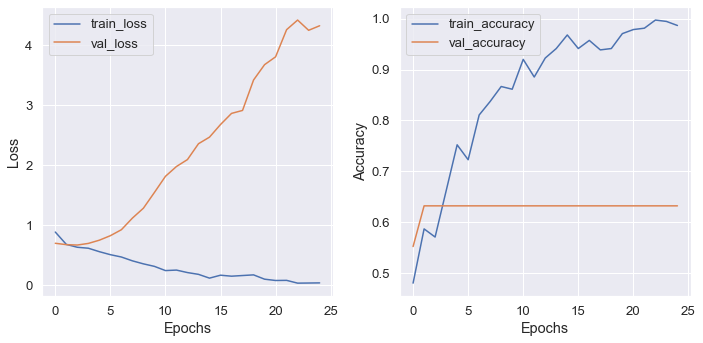

In [230]:
plot_metrics(model_21_results)

recall v precision: recall prioritizes minimizing false negatives, precision minimizes false positives. We don't want to miss a potential diagnosis and call it normal, so we need to prioritize recall.

Then:
1. train test split (DONE)
2. baseline model (DONE)
3. fsm (DONE)
4. ssm, tsm, etc. until final
5. try gridsearching
6. fine tune activators, optimizers, how many units per layer, num of layers, etc.
7. print scores, plot loss/accuracy/recall, confusion matrix, roc curves. can do functions
8. use sequential models to start, look up other architectures
9. conclusion & next steps

Each session should have: 
1. create model, fit it, look at results, save both model and results
2. loss/accuracy plots, confusion matrices, roc curves
3. explanation of metrics, work out next model, etc.
4. maybe at the end can add a ranking
5. maybe print out some of the predicted labels for an image, inspect it visually